# Integration of stiff ODEs

#### Jahid Md Hassan & Benjamin Vogel 

In [23]:
import numpy as np
import scipy as scp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

## 1. Curtis and Hirschfelder example

#### Problem definition and analysis of exact solution

In [24]:
#
# defining the model and exact solution
#

def model(t,y,l=5):
    '''
    t : current time t
    y : evaluation of y at time t
    l : lambda parameter > 1
    '''
    return l*(-y+np.cos(t))

def exact_solution(t,y_0,l=5):
    '''
    t   : current time t
    y_0 : inital value 
    l   : lambda parameter > 1
    '''
    lam = (l / (1+l**2))
    C = y_0 - l*lam
    
    return C*np.exp(-l*t) + l*lam*np.cos(t) + lam*np.sin(t)


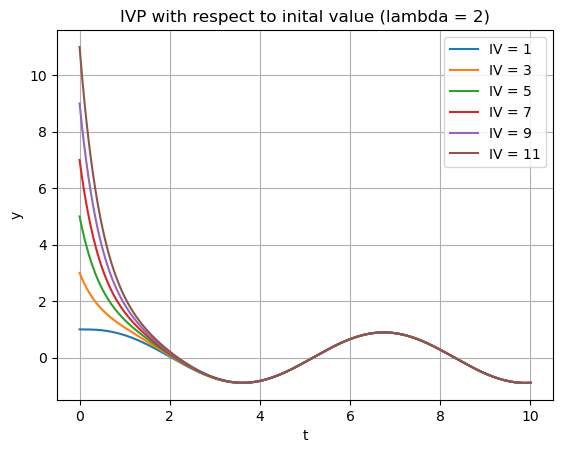

In [25]:
#
# analysis of exact solution with respect to initial value
#
initial_values = np.arange(1,13,2)
x_space = np.linspace(0,10,1000)

for iv in initial_values:
    exact_y = exact_solution(x_space,iv,2)
    plt.plot(x_space, exact_y,label=f"IV = {iv}")
plt.xlabel("t")
plt.ylabel("y")
plt.title("IVP with respect to inital value (lambda = 2)")
plt.legend()
plt.grid()

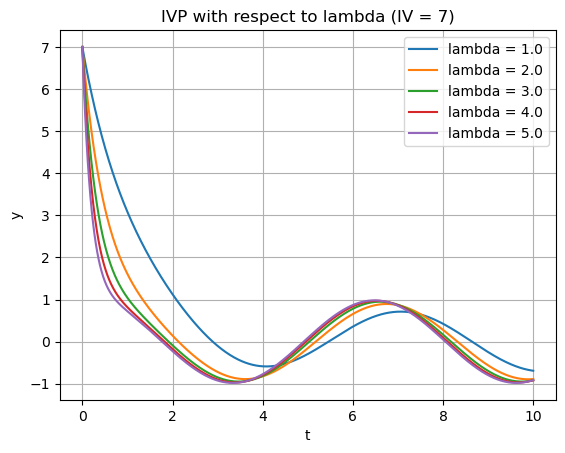

In [26]:
#
# analysis of exact solution with respect to lambda
#
lambda_values = np.linspace(1,5,5)
x_space = np.linspace(0,10,1000)

for lv in lambda_values:
    exact_y = exact_solution(x_space,7,lv)
    plt.plot(x_space, exact_y,label=f"lambda = {lv}")
plt.xlabel("t")
plt.ylabel("y")
plt.title("IVP with respect to lambda (IV = 7)")
plt.legend()
plt.grid()

### Solving the Initial Value problem Numerically with explicit methods

In [27]:
#
# defining the explicit methods
#

def forward_euler(f,y,h,t):
    '''
    f   : ODE function f(t,y(t))
    y   : current evaluation
    h   : time step size
    t   : current time
    
    uses left euler method to approximate integral 
    '''
    return y + h * f(t,y)

def explicit_RK_2(f,y,h,t):
    '''
    f   : ODE function f(t,y(t))
    y   : current evaluation
    h   : time step size
    t   : current time
    
    uses second order Runge-Kutta method to approximate integral 
    '''
    k1 = f(t,y)
    k2 = f(t+h/2, y + (h/2)*k1)
    return y + h*k2

#
# defining the IVP solver
#

def IVP(f,y_init,h,time,method=forward_euler,l=2):
    # storage for evaluations at every iteration
    steps = [y_init]
    t_values = [0]
    current_time = 0
    y_current = y_init
    
    while current_time < time:
        y_next = method(f, y_current, h, current_time)
        steps.append(y_next)
        current_time += h
        t_values.append(current_time)
        y_current = y_next
    
    return np.array(t_values), np.array(steps)

In [28]:
#
# defining a visualizer for the IVP solver results
#

def visualize_IVP(ts, ys, descirption="Diagramm"):
    plt.plot(ts,ys,label=descirption)
    
#
# defining error function
#

def Errors(x ,xref):
    abs_err = abs(x-xref)
    rel_err = abs((x-xref)/x)
    return abs_err, rel_err

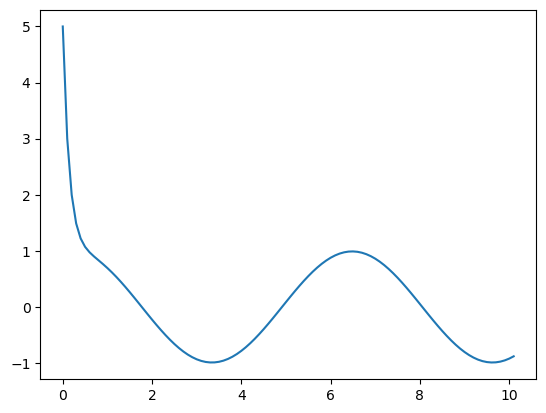

In [29]:
visualize_IVP(*IVP(model,5,.1,10,forward_euler), "Verify implementation")

### Stability limits of the explicit methods

#### **Stability Region for the Forward Euler Method**
---

The update formula for the Forward Euler method is:

$$
y_{n+1} = y_n + \Delta t \cdot \lambda y_n
$$

This can be generalized as:

$$
y_{n+1} = G \cdot y_n, \quad \text{where} \quad G = 1 + \Delta t \lambda
$$

The stability condition requires that the amplification factor satisfies:

$$
|G| = \left|1 + \Delta t \lambda \right| \leq 1
$$

Let $ \Delta t \lambda = a + i b $. Substituting this into $ G $, we get:

$$
G = 1 + (a + i b)
$$

Expanding $ G $, the real and imaginary parts are:

- Real part:  
  $$
  \text{Re}(G) = 1 + a
  $$

- Imaginary part:  
  $$
  \text{Im}(G) = b
  $$

Substituting the expressions for $ \text{Re}(G) $ and $ \text{Im}(G) $, the magnitude of $ G $ becomes:

$$
|G| = \sqrt{(1 + a)^2 + b^2}
$$

The stability region is defined by the condition:

$$
(1 + a)^2 + b^2 \leq 1^2
$$


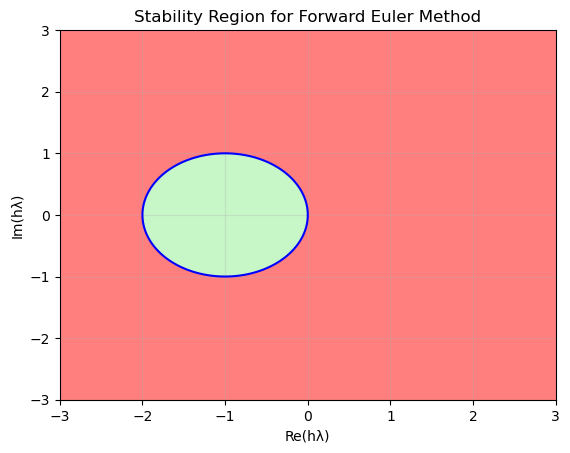

In [30]:
# Explicit Eular Stability region.  
def forward_stability():
    x_space = np.linspace(-3, 3, 500)
    y_space = np.linspace(-3, 3, 500)
    X, Y = np.meshgrid(x_space, y_space)
    
    # Stability condition: Circle centered at (-1, 0) with radius 1
    condition = (1+X)**2 + Y**2
    
    plt.contourf(X, Y, condition, levels=[0, 1], colors=['lightgreen'], alpha=0.5)  
    plt.contourf(X, Y, condition, levels=[1, 100], colors=['red'], alpha=0.5)       
    plt.contour(X, Y, condition, levels=[1], colors='blue', linewidths=1.5)         
    
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.title('Stability Region for Forward Euler Method', fontsize=12)
    plt.xlabel('Re(hλ)', fontsize=10)
    plt.ylabel('Im(hλ)', fontsize=10)
    plt.grid(alpha=0.3)
    
forward_stability()

#### **Stability Region for the Implicit Euler Method**
---

The update formula for the Implicit Euler method is:

$$
y_{n+1} = y_n + \Delta t \cdot \lambda y_{n+1}
$$

Rearranging to isolate $ y_{n+1} $, we get:

$$
y_{n+1} = \frac{y_n}{1 - \Delta t \lambda}
$$

This can be generalized as:

$$
y_{n+1} = G \cdot y_n, \quad \text{where} \quad G = \frac{1}{1 - \Delta t \lambda}
$$

The stability condition requires that the amplification factor satisfies:

$$
|G| = \left| \frac{1}{1 - \Delta t \lambda} \right| \leq 1
$$

Let $ \Delta t \lambda = a + i b $. Substituting this into $ G $, we get:

$$
G = \frac{1}{1 - (a + i b)}
$$

To simplify, multiply the numerator and denominator by the conjugate of the denominator:

$$
G = \frac{1 - (a - i b)}{(1 - a)^2 + b^2}
$$

Expanding $ G $, the real and imaginary parts are:

- Real part:  
  $$
  \text{Re}(G) = \frac{1 - a}{(1 - a)^2 + b^2}
  $$

- Imaginary part:  
  $$
  \text{Im}(G) = \frac{b}{(1 - a)^2 + b^2}
  $$

Substituting the expressions for $ \text{Re}(G) $ and $ \text{Im}(G) $, the magnitude of $ G $ becomes:

$$
|G| = \sqrt{\text{Re}(G)^2 + \text{Im}(G)^2} = \frac{1}{\sqrt{(1 - a)^2 + b^2}}
$$

The stability region is defined by the condition:

$$
\frac{1}{\sqrt{(1 - a)^2 + b^2}} \leq 1
$$

Simplifying further, this implies:

$$
(1 - a)^2 + b^2 \geq 1^2
$$


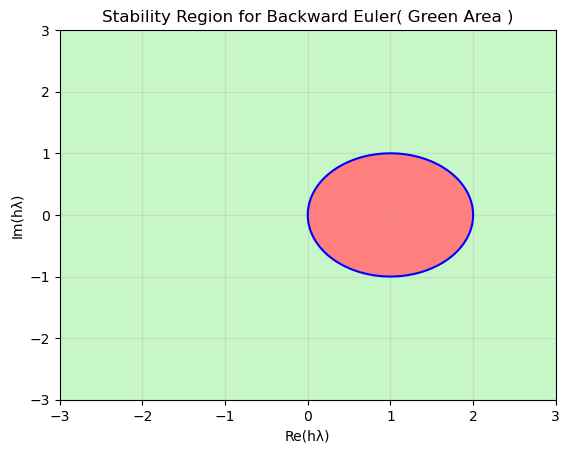

In [31]:
# Implicit Eular stability region 
def implicit_stability():
    x_space = np.linspace(-3, 3, 500)
    y_space = np.linspace(-3, 3, 500)
    X, Y = np.meshgrid(x_space, y_space)

    condition = (1-X)**2 + Y**2

    # Plotting
    plt.contourf(X, Y, condition, levels=[0, 1], colors=['red'], alpha=0.5)  
    plt.contourf(X, Y, condition, levels=[1, 100], colors=['lightgreen'], alpha=0.5)      
    plt.contour(X, Y, condition, levels=[1], colors='blue', linewidths=1.5)     

    # Styling
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.title('Stability Region for Backward Euler( Green Area )', fontsize=12)
    plt.xlabel('Re(hλ)', fontsize=10)
    plt.ylabel('Im(hλ)', fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

implicit_stability()

#### **Stability Region for the 2nd Order Runge-Kutta Method**
---
The update formula for the 2nd Order Runge-Kutta (RK2) method is:

$$
y_{n+1} = y_n + \Delta t \cdot \lambda y_n \left(1 + \frac{\Delta t \lambda}{2}\right)
$$

This can be generalized as:

$$
y_{n+1} = G \cdot y_n, \quad \text{where} \quad G = 1 + \Delta t \lambda + \frac{(\Delta t \lambda)^2}{2}
$$

The stability condition requires that the amplification factor satisfies:

$$
|G| = \left|1 + \Delta t \lambda + \frac{(\Delta t \lambda)^2}{2}\right| \leq 1
$$

Let $ \Delta t \lambda = a + i b $. Substituting this into $ G $, we get:

$$
G = 1 + (a + i b) + \frac{(a + i b)^2}{2}
$$

Expanding $ G $, the real and imaginary parts are:

- Real part:  
  $$
  \text{Re}(G) = 1 + a + \frac{a^2 - b^2}{2}
  $$

- Imaginary part:  
  $$
  \text{Im}(G) = b + a b
  $$

Substituting the expressions for $ \text{Re}(G) $ and $ \text{Im}(G) $, the stability region is determined by:

$$
G_{\text{magnitude}} = \sqrt{\text{Re}(G)^2 + \text{Im}(G)^2} \leq 1
$$


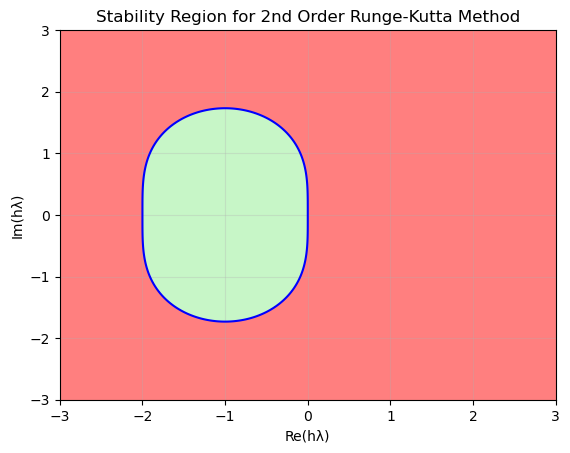

In [32]:
# Runge-Kutta 2nd Order Stability region 

def explicit_RK_2_stability():
    x_space = np.linspace(-3, 3, 500)
    y_space = np.linspace(-3, 3, 500)
    X, Y = np.meshgrid(x_space, y_space)
    
    Re_G = 1 + X + (X**2)/2 - (Y**2)/2  
    Im_G = Y +  X * Y       
    G_magnitude = np.sqrt(Re_G**2 + Im_G**2)  #
    
    plt.contourf(X, Y, G_magnitude, levels=[0, 1], colors=['lightgreen'], alpha=0.5)  
    plt.contourf(X, Y, G_magnitude, levels=[1, 100], colors=['red'], alpha=0.5)       
    plt.contour(X, Y, G_magnitude, levels=[1], colors='blue', linewidths=1.5)         
    
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.title('Stability Region for 2nd Order Runge-Kutta Method', fontsize=12)
    plt.xlabel('Re(hλ)', fontsize=10)
    plt.ylabel('Im(hλ)', fontsize=10)
    plt.grid(alpha=0.3)

explicit_RK_2_stability()

### Stability for differnt Step size 

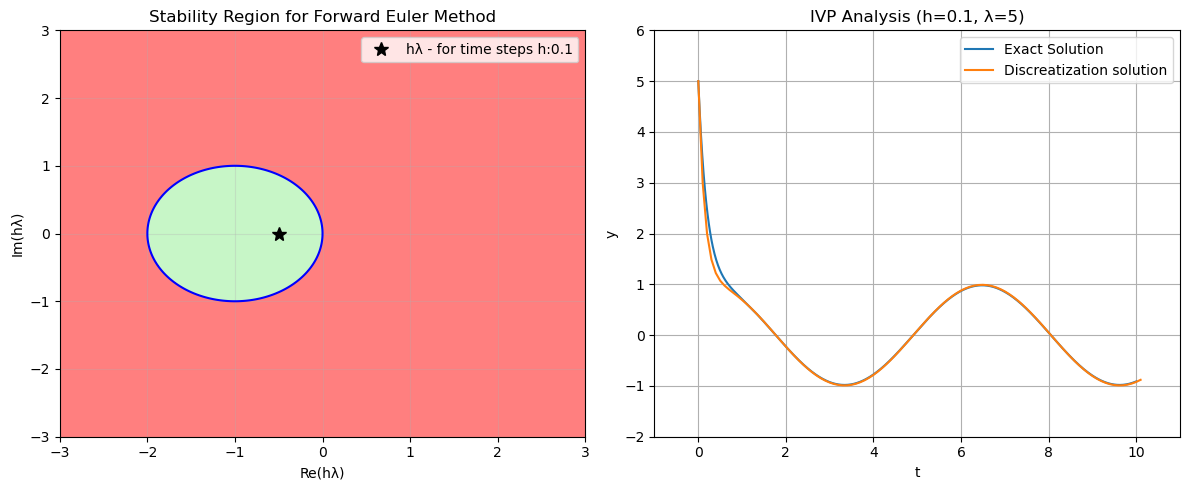

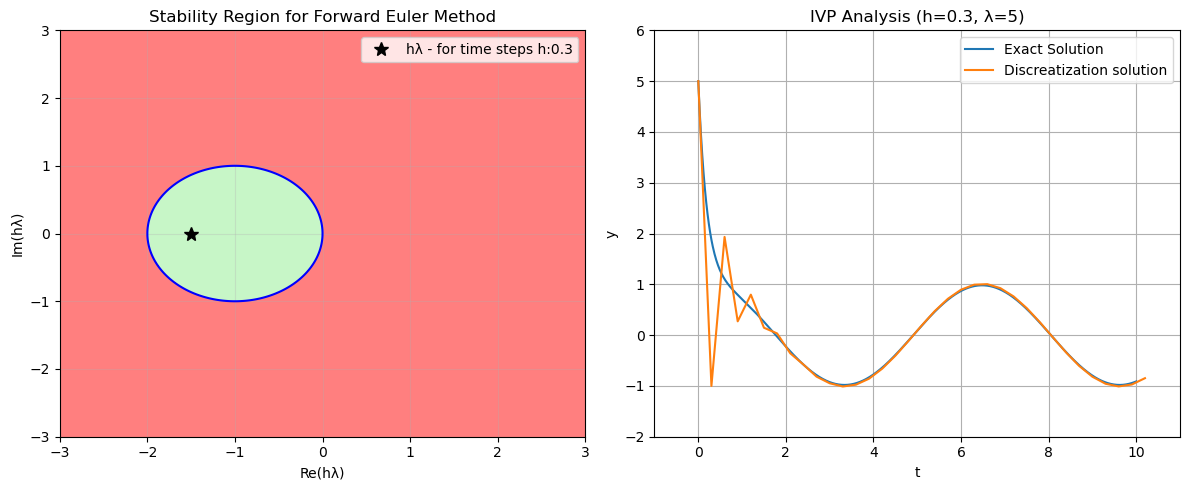

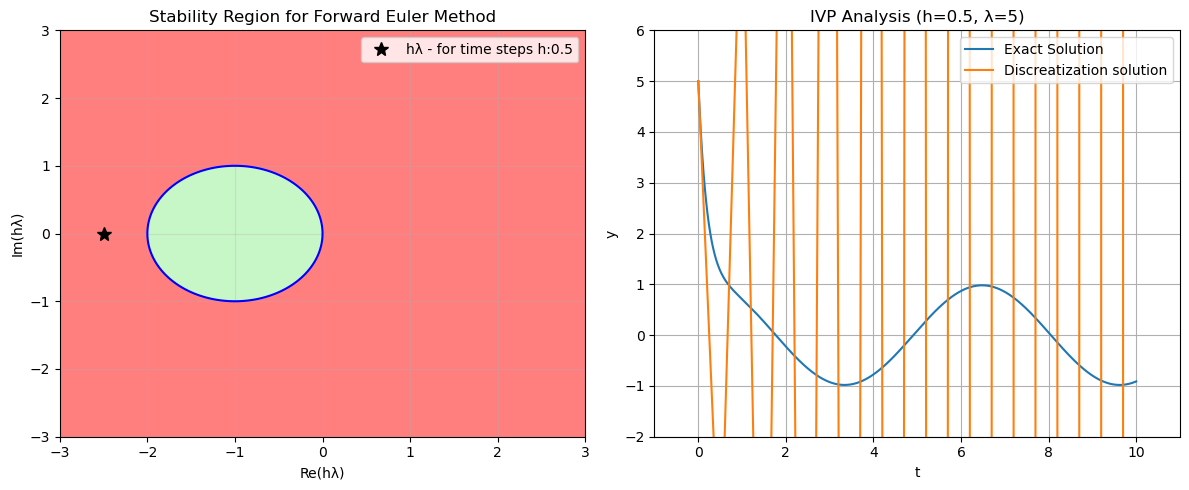

In [33]:
def plot_point(h, l):
    x = h * -l
    plt.plot(x, 0, '*', color='black', markersize=10, label=f'hλ - for time steps h:{h}')
    plt.legend()

h_values = [0.1, 0.3, 0.5]  
l = 5
t_max = 10

for h in h_values:
    plt.figure(figsize=(12, 5))
    
    # Left plot: Stability region 
    plt.subplot(1, 2, 1)
    forward_stability()        
    plot_point(h, l)          
    
    # Right plot: Exact and discretized solutions 
    plt.subplot(1, 2, 2)
    x_space = np.linspace(0, t_max, 1000)
    exact_y = exact_solution(x_space, 5, l=l)  
    plt.plot(x_space, exact_y, label="Exact Solution", linewidth=1.5)
    visualize_IVP(*IVP(lambda t, y: model(t, y, l=l), 5, h, 10, forward_euler, l=l), "Discreatization solution")
    plt.xlabel("t")
    plt.ylabel("y")
    plt.title(f"IVP Analysis (h={h}, λ={l})")
    plt.xlim([-1, 11])
    plt.ylim([-2, 6])
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()


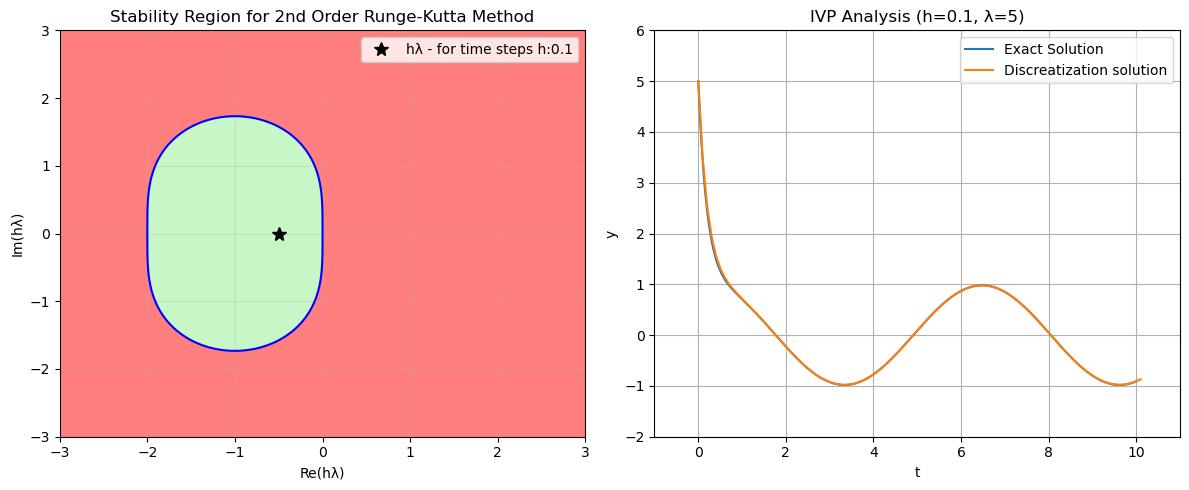

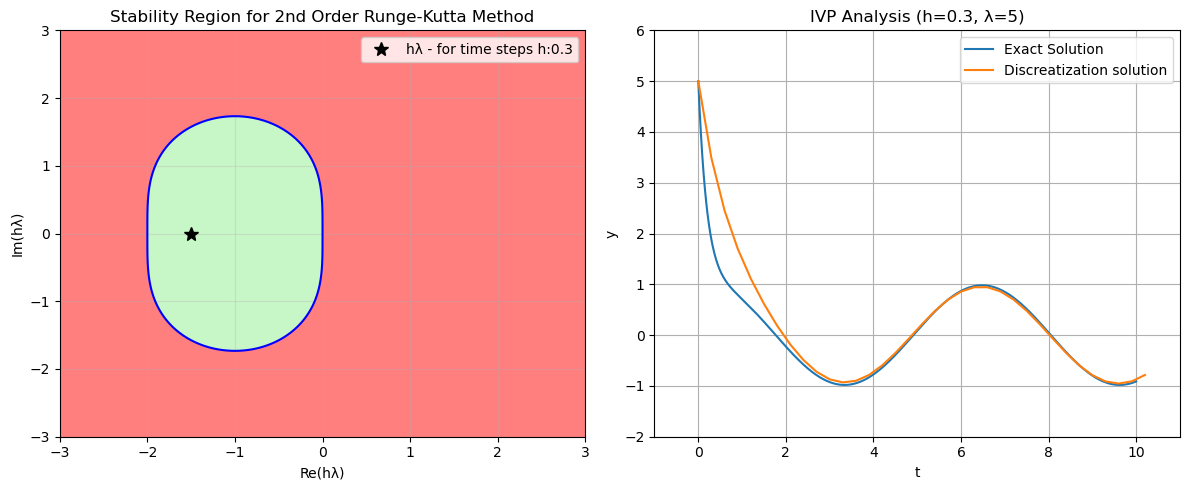

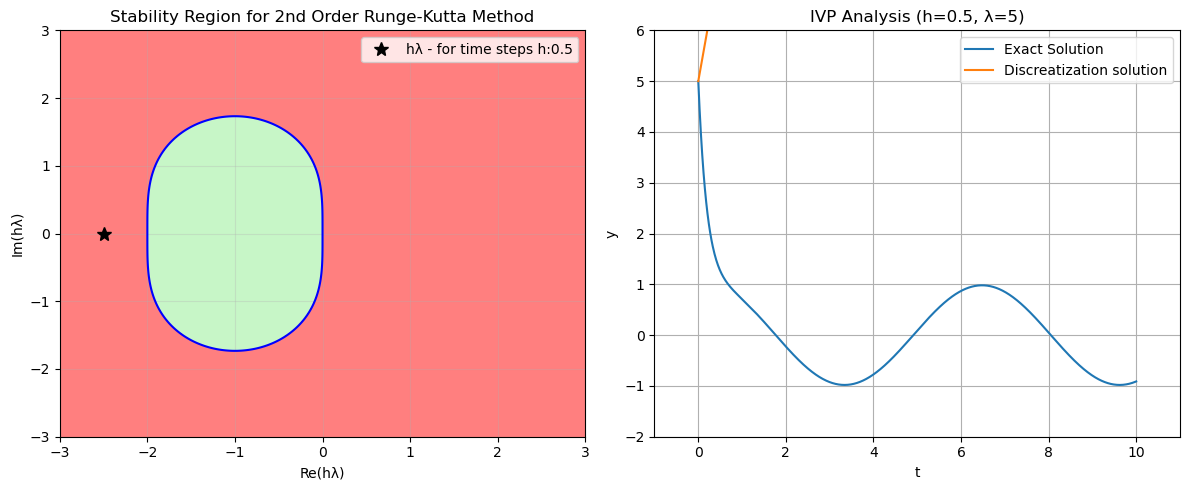

In [34]:
def plot_point(h, l):
    x = h * -l
    plt.plot(x, 0, '*', color='black', markersize=10, label=f'hλ - for time steps h:{h}')
    plt.legend()

h_values = [0.1, 0.3, 0.5]  
l = 5
t_max = 10

for h in h_values:
    plt.figure(figsize=(12, 5))
    
    # Left plot: Stability region 
    plt.subplot(1, 2, 1)
    explicit_RK_2_stability()      
    plot_point(h, l)          
    
    # Right plot: Exact and discretized solutions 
    plt.subplot(1, 2, 2)
    x_space = np.linspace(0, t_max, 1000)
    exact_y = exact_solution(x_space, 5, l=l)  
    plt.plot(x_space, exact_y, label="Exact Solution", linewidth=1.5)
    visualize_IVP(*IVP(lambda t, y: model(t, y, l=l), 5, h, 10, explicit_RK_2, l=l), "Discreatization solution")
    plt.xlabel("t")
    plt.ylabel("y")
    plt.title(f"IVP Analysis (h={h}, λ={l})")
    plt.xlim([-1, 11])
    plt.ylim([-2, 6])
    plt.legend()
    plt.grid()
    
    plt.tight_layout()
    plt.show()


In [60]:
#
# following function plots IVP with different time steps and plots
# the local error, the evolution of IVP and the y_n+1 / y_n ratio
#
def plot_discretization_error(f,true_behaviour,y_init,time,six_time_steps=[0.01,0.1,0.2,0.5,0.75,1],method=forward_euler):
    '''
    plots y_n+1 / y_n along side the acctual outputs
    '''
    fig, axs = plt.subplots(3, 2, figsize=(15, 10)) 
    axs = axs.flatten()
    steps = six_time_steps
    k = 0
    for h in steps:
        ts,vs = IVP(f,y_init,h,time,method)
        amp = []
        local_err = []
        for idx in range(len(vs)-1):
            r = (vs[idx+1]/vs[idx])
            le = np.abs(true_behaviour(ts[idx],y_init) - vs[idx])
            amp.append(r)
            local_err.append(le)
        local_err.append(np.abs(true_behaviour(ts[-1],y_init) - vs[-1]))
        #axs[k].plot(ts[1:],amp, label="amplification")
        axs[k].plot(ts,local_err, label="local error")
        axs[k].plot(ts,vs, label="IVP")
        axs[k].set_title(f"h = {h}")
        axs[k].set_xlabel(f"t")
        axs[k].set_ylim(-y_init-2,y_init+2)
        axs[k].legend()
        axs[k].grid()
        k += 1
    fig.tight_layout()
    

In [72]:
#
# convergence plot
#

def convergence_plot(f,true_behaviour,y_init,time,method=forward_euler):
    h_log_space = np.logspace(-3,0,100)
    g_err = []
    for h in h_log_space:
        ts,vs = IVP(f,y_init,h,time,method)
        true_vs = true_behaviour(ts,y_init)
        global_err = np.sqrt(np.sum(np.power(vs - true_vs,2)) * h)
        g_err.append(global_err)
    plt.grid()
    plt.xlabel("h")
    plt.ylabel("L^2-error")
    plt.loglog(h_log_space,g_err)
    

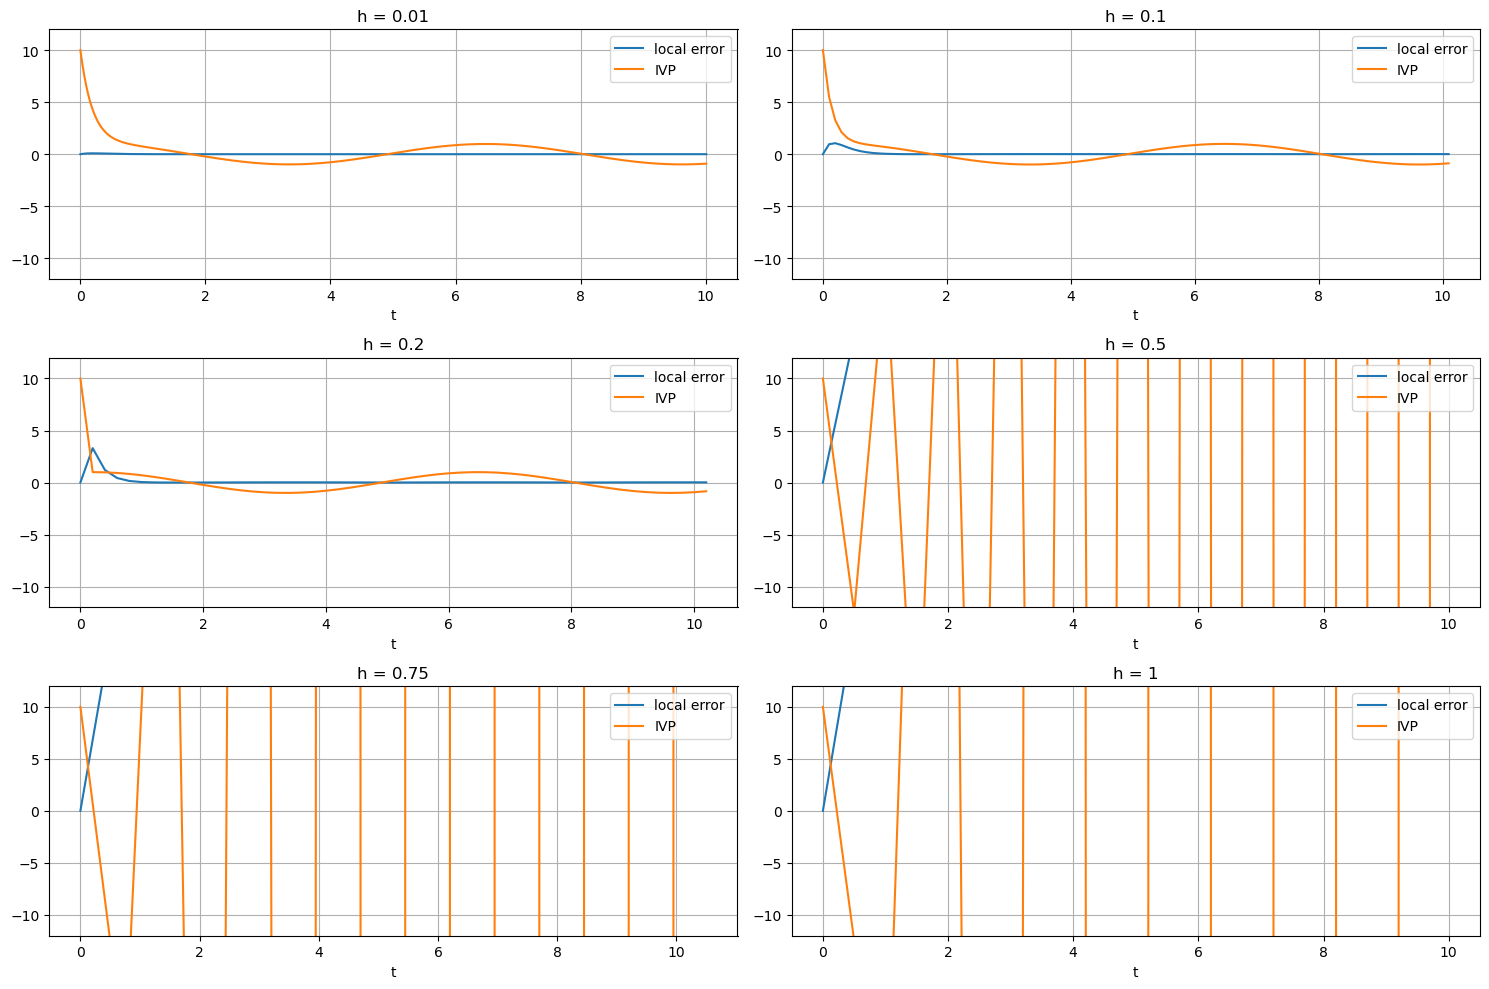

In [73]:
#
# forward euler
#
m = lambda t,y : model(t,y,l=5)
plot_discretization_error(m,exact_solution,10,10)

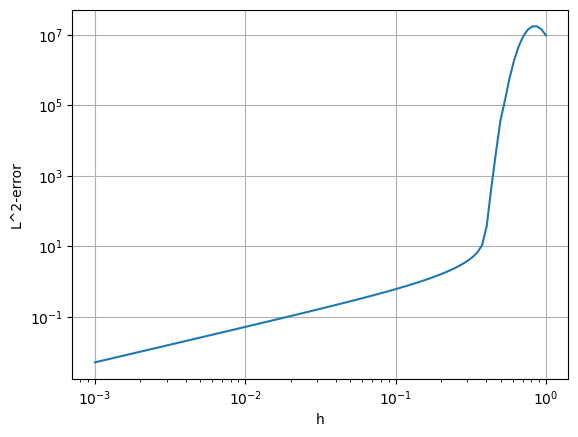

In [74]:
convergence_plot(m,exact_solution,10,10,method=forward_euler)

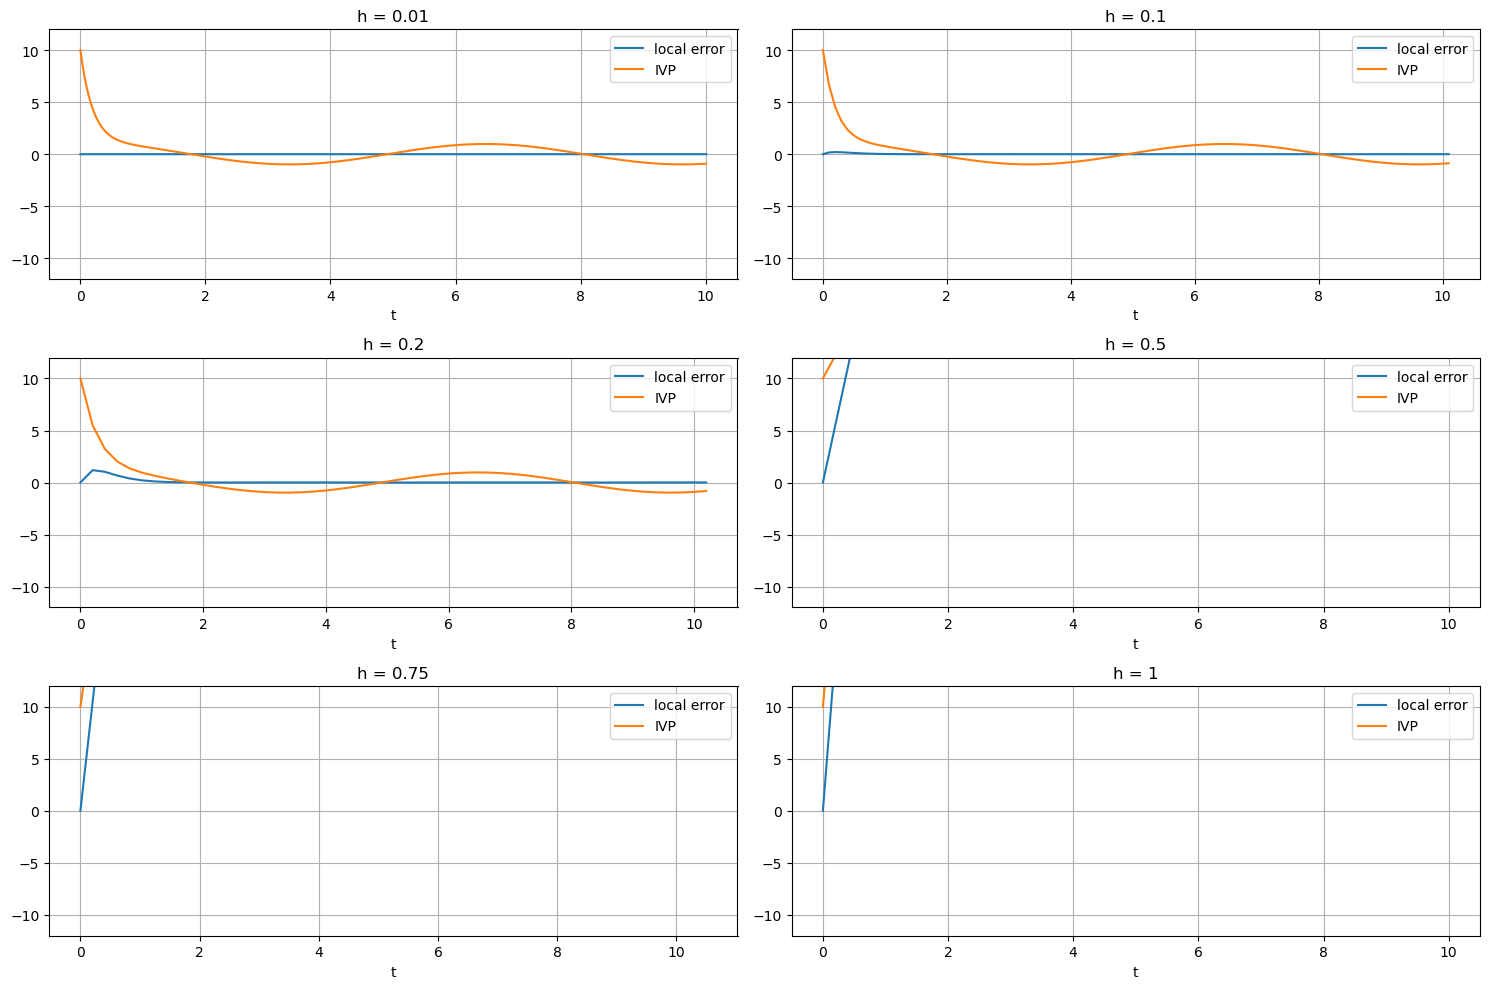

In [75]:
#
# 2-RK
#
m = lambda t,y : model(t,y,l=5)
plot_discretization_error(m,exact_solution,10,10,method=explicit_RK_2)

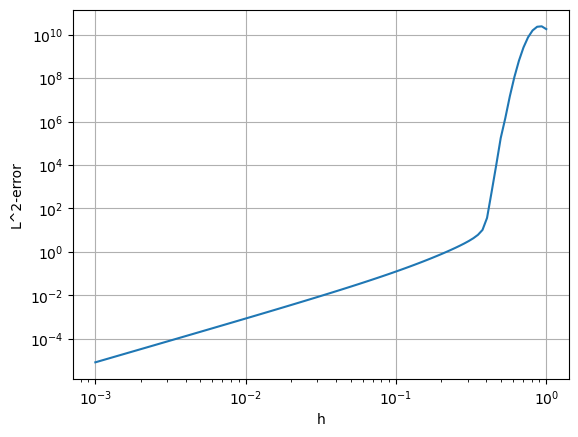

In [76]:
convergence_plot(m,exact_solution,10,10,method=explicit_RK_2)

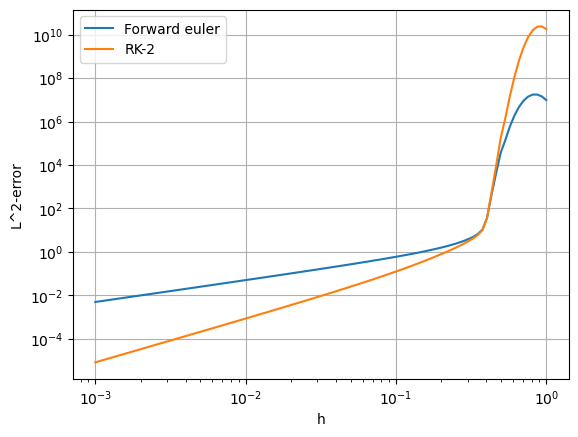

In [77]:
convergence_plot(m,exact_solution,10,10,method=forward_euler)
convergence_plot(m,exact_solution,10,10,method=explicit_RK_2)
plt.grid()
plt.legend(["Forward euler","RK-2"])

#### Drawbacks of explicit methods with fast and slow dynamics

The main issue with using explicit methods with fast and slow dynamics is choosing the step size. Because there are fast dynamics, it is important to have a small step size to ensure stability and convergences. However this causes unnecessary computational costs for the dynamically slow periods of the problem, because many steps are taken for regions where such accuracy is not needed. 

Similarly, when taking a larger step size to reduce the computational cost of the periods with slow dynamics, the fast dynamical regions loose wont be computed accurately.

#### What we would expect when solving more complex problems in term of computational time

We would expect problems to become even more computationally expensive for more complex problems. This would require us to determine numerical methods that do not waste time with unecessary precision in slow-dynamical periods.

### Solving the Initial Value problem Numerically with implicit methods

In [78]:
#
# defining implicit backward euler method
#

def backward_euler(f,y,h,t):
    def implicit_eq(y_next):
        return y_next - y - h * f(t + h, y_next)

    y_next = fsolve(implicit_eq, y)[0]
    return y_next



C:\Users\benvo\AppData\Local\Temp\ipykernel_19160\125987254.py:9: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  y_next = fsolve(implicit_eq, y)[0]


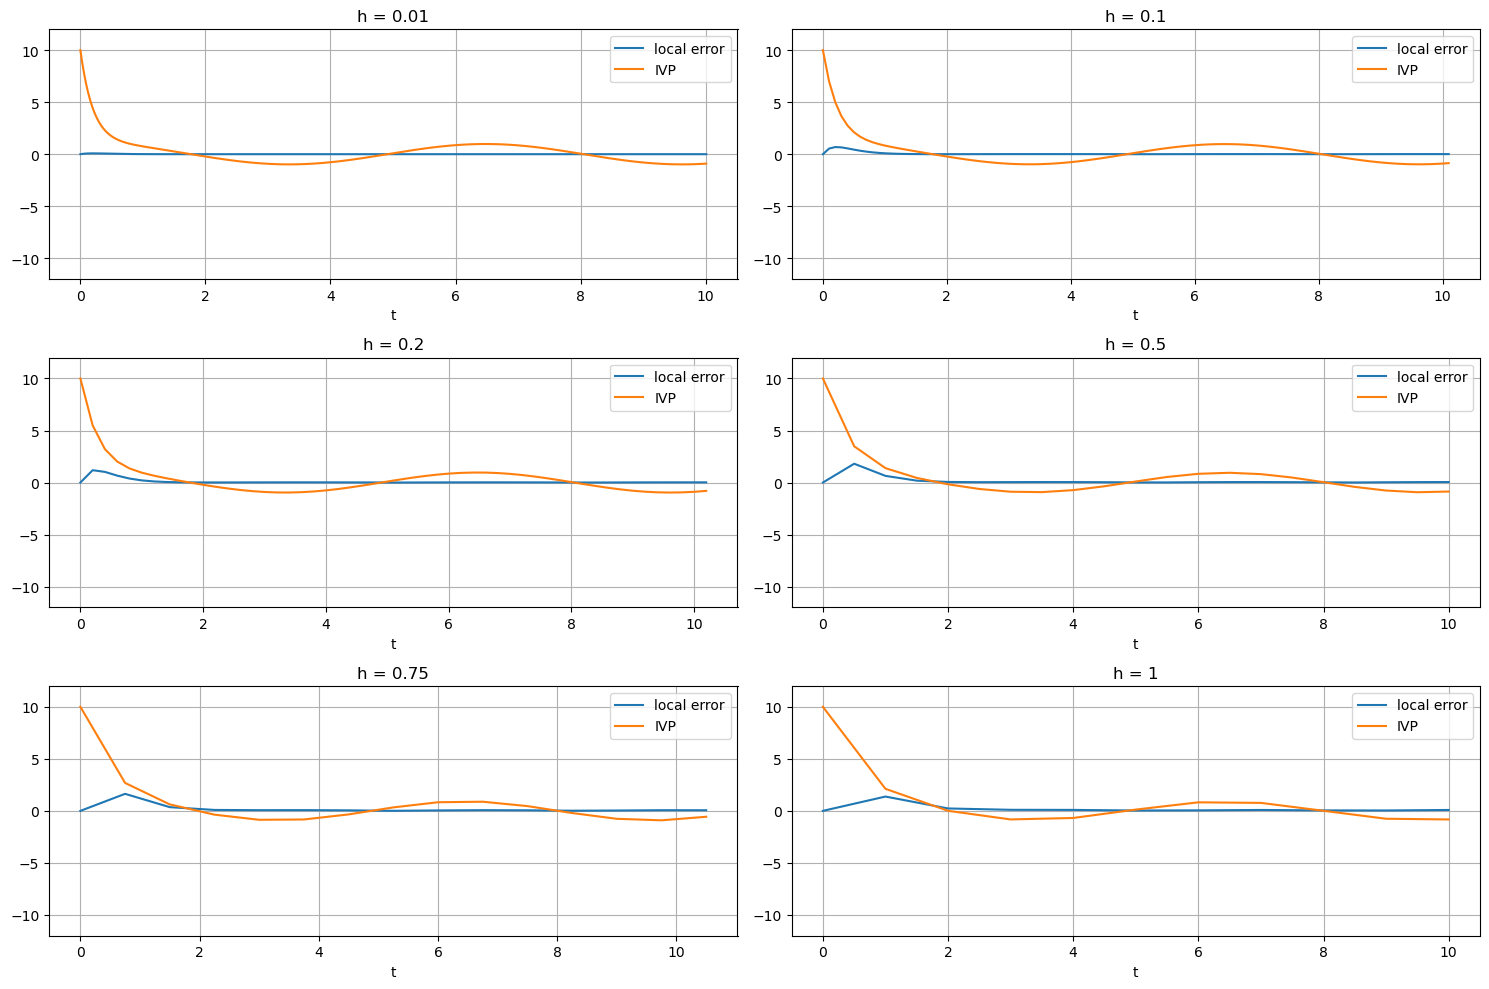

In [79]:
m = lambda t,y : model(t,y,l=5)
plot_discretization_error(m,exact_solution,10,10,method=backward_euler)

C:\Users\benvo\AppData\Local\Temp\ipykernel_19160\125987254.py:9: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  y_next = fsolve(implicit_eq, y)[0]


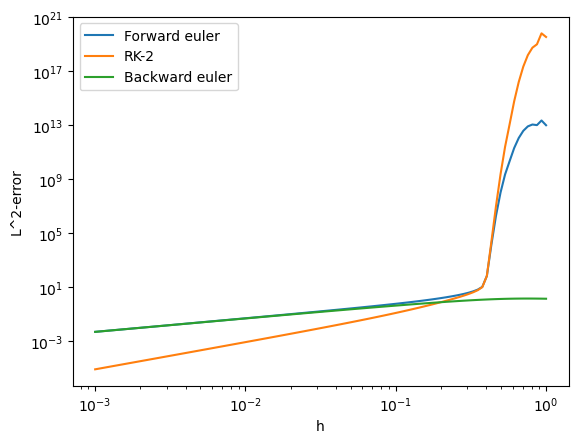

In [80]:
convergence_plot(m,exact_solution,10,20,method=forward_euler)
convergence_plot(m,exact_solution,10,20,method=explicit_RK_2)
convergence_plot(m,exact_solution,10,20,method=backward_euler)
plt.grid()
plt.legend(["Forward euler","RK-2","Backward euler"])

#### Stability + quality of approximation

The Stability of the implicit method is great. The method remains stable, even for large step sizes.

Regarding the quality of the approximation, the implicit method manages to approximate the steady state very well. Nonetheless, the fast-dynamical region is only well approximated for small time steps. Either way, the method manages to resolve the boundary layer.

#### Order and convergence of the methods

C:\Users\benvo\AppData\Local\Temp\ipykernel_19160\125987254.py:9: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  y_next = fsolve(implicit_eq, y)[0]


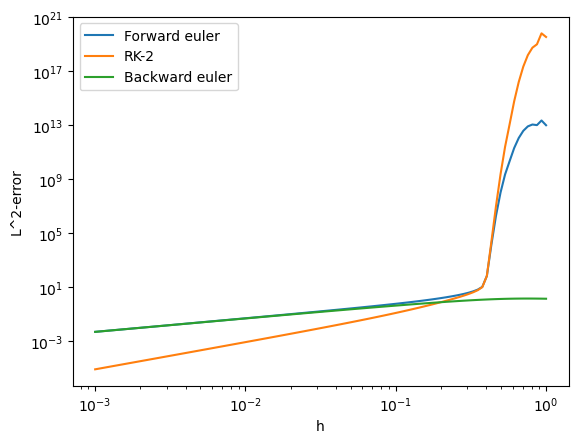

In [81]:
convergence_plot(m,exact_solution,10,20,method=forward_euler)
convergence_plot(m,exact_solution,10,20,method=explicit_RK_2)
convergence_plot(m,exact_solution,10,20,method=backward_euler)
plt.grid()
plt.legend(["Forward euler","RK-2","Backward euler"])

C:\Users\benvo\AppData\Local\Temp\ipykernel_19160\125987254.py:9: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  y_next = fsolve(implicit_eq, y)[0]


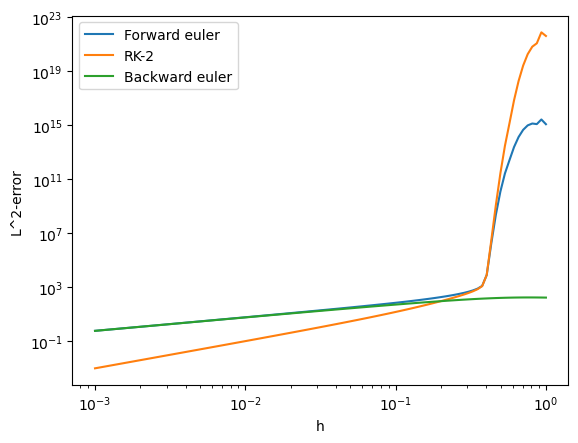

In [82]:
convergence_plot(m,exact_solution,1000,20,method=forward_euler)
convergence_plot(m,exact_solution,1000,20,method=explicit_RK_2)
convergence_plot(m,exact_solution,1000,20,method=backward_euler)
plt.grid()
plt.legend(["Forward euler","RK-2","Backward euler"])

### Observation
When the simulation start very far from the steady state solution, we do not observe a linear or quadratic relationship between errors and the time step.